## Setup

In [45]:
GLOBAL_SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)
import glob
import sys
import shutil
import pickle
import random as rnd
from tqdm import tqdm

import numpy as np
from numpy import random as np_rnd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model as lm
from sklearn import metrics

import lightgbm as lgb

import librosa

import torch
from torch import nn
from torch.nn import functional as F

In [46]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    except:
        pass

def pickleIO(obj, src, op="w"):
    if op == "w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op == "r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj
    
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]
    
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
        
def week_of_month(dt):
    """ 
        Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + (1 + first_day.weekday()) % 7
    return int(np.ceil(adjusted_dom/7.0))

def get_season(dt):
    dt = int(dt)
    if dt in [3, 4, 5]:
        return 0
    elif dt in [6, 7, 8]:
        return 1
    elif dt in [9, 10, 11]:
        return 2
    else:
        return 3

In [47]:
class CFG:
    debug = False
    data_path = ".\\data\\"
    
    n_mfcc = 32
    n_chroma = 16

## Loading data

In [48]:
# Save datasets
df_train = pickleIO(None, "./dataset/df_train.pkl", "r")
df_valid = pickleIO(None, "./dataset/df_valid.pkl", "r")

In [49]:
df_train

,data_path,type,timestamp,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,rms_0,rms_1,rms_2,rms_3,rms_4,rms_5,month,season,temp,hum
8053,.\data\abdominal\abdominal_202209\train_abdomi...,abdominal,2022-09-01,0.100375,-152.008209,114.103264,-6.809704,-13.400922,2.236301,4.635829,...,0.043832,0.006729,0.053669,0.031314,0.022355,0.713902,9,2,26.532222,78.021111
9055,.\data\abdominal\abdominal_202210\train_abdomi...,abdominal,2022-10-01,0.071383,-194.701126,152.761902,-20.654911,4.816885,-13.634759,10.529870,...,0.042325,0.008508,0.054016,0.025527,0.028489,1.116019,10,2,20.590323,64.034409
7528,.\data\abdominal\abdominal_202209\train_abdomi...,abdominal,2022-09-01,0.105982,-154.330490,111.065445,-28.823948,20.789288,-3.794430,21.345968,...,0.041040,0.009133,0.056500,0.025861,0.030639,1.184786,9,2,26.532222,78.021111
9001,.\data\abdominal\abdominal_202210\train_abdomi...,abdominal,2022-10-01,0.091739,-168.230530,135.824020,-32.273739,10.225665,-4.109786,9.913898,...,0.047252,0.009714,0.065793,0.035313,0.030480,0.863135,10,2,20.590323,64.034409
7073,.\data\abdominal\abdominal_202209\train_abdomi...,abdominal,2022-09-01,0.133309,-55.229809,104.472702,-40.752758,12.543762,-34.147350,11.086745,...,0.126325,0.065481,0.240394,0.043419,0.196975,4.536574,9,2,26.532222,78.021111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,.\data\abdominal\abdominal_202210\train_abdomi...,abdominal,2022-10-01,0.094740,-166.271500,128.656921,-20.329794,-2.984057,-4.430411,5.766476,...,0.043196,0.008440,0.055936,0.025718,0.030217,1.174952,10,2,20.590323,64.034409
4441,.\data\dry\dry_202302\train_dry_13890.wav,dry,2023-02-01,0.110137,-103.181274,112.578857,-19.416920,17.093378,-13.513755,12.859381,...,0.067428,0.010854,0.084913,0.049394,0.035519,0.719080,2,3,7.042693,51.873399
2303,.\data\dry\dry_202211\train_dry_07809.wav,dry,2022-11-01,0.110293,-97.368134,109.255257,-16.161146,21.142416,-20.549458,7.729898,...,0.075805,0.014018,0.097809,0.048181,0.049628,1.030047,11,2,12.853333,55.112222
2420,.\data\dry\dry_202212\train_dry_08049.wav,dry,2022-12-01,0.126861,-54.028755,107.528053,-27.415445,25.679974,-29.958881,6.513360,...,0.109673,0.020581,0.141579,0.058601,0.082978,1.415970,12,3,4.760215,47.618280


In [50]:
df_valid

,data_path,type,timestamp,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,rms_0,rms_1,rms_2,rms_3,rms_4,rms_5,month,season,temp,hum
15964,.\data\abdominal\abdominal_202303\train_abdomi...,abdominal,2023-03-01,0.127317,-129.935684,120.849190,-57.607597,-1.361679,9.187469,-1.416911,...,0.078874,0.038915,0.138307,0.018661,0.119646,6.411605,3,0,13.506452,58.259140
5592,.\data\abdominal\abdominal_202208\train_abdomi...,abdominal,2022-08-01,0.107439,-172.269699,118.385941,-35.123390,-0.768732,-13.109409,7.783858,...,0.037951,0.014019,0.058832,0.013265,0.045568,3.435256,8,1,30.219355,80.798925
2569,.\data\dry\dry_202212\train_dry_08383.wav,dry,2022-12-01,0.131083,-70.272850,93.061905,-23.908194,19.563688,-16.200703,12.072376,...,0.099741,0.049849,0.226470,0.057848,0.168622,2.914919,12,3,4.760215,47.618280
6694,.\data\abdominal\abdominal_202208\train_abdomi...,abdominal,2022-08-01,0.069195,-205.911087,147.817291,-35.009632,9.234331,-5.329868,13.523920,...,0.046749,0.015951,0.068912,0.015650,0.053262,3.403417,8,1,30.219355,80.798925
9192,.\data\abdominal\abdominal_202210\train_abdomi...,abdominal,2022-10-01,0.103156,-170.419708,130.740021,-37.892384,14.527298,-9.853578,9.035569,...,0.037664,0.010373,0.051824,0.018760,0.033065,1.762541,10,2,20.590323,64.034409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8329,.\data\abdominal\abdominal_202210\train_abdomi...,abdominal,2022-10-01,0.108994,-71.564240,133.406113,-64.242844,-0.741359,-14.942988,-2.030332,...,0.137886,0.055763,0.209324,0.038656,0.170668,4.415051,10,2,20.590323,64.034409
6962,.\data\abdominal\abdominal_202208\train_abdomi...,abdominal,2022-08-01,0.104523,-193.763641,129.363861,-47.244011,11.891455,-7.298118,11.752427,...,0.031929,0.008256,0.043753,0.016167,0.027585,1.706237,8,1,30.219355,80.798925
5585,.\data\abdominal\abdominal_202208\train_abdomi...,abdominal,2022-08-01,0.079260,-154.604126,146.838577,-37.803913,-2.129235,-11.512072,18.544447,...,0.080659,0.031508,0.125135,0.033550,0.091585,2.729756,8,1,30.219355,80.798925
2677,.\data\dry\dry_202212\train_dry_08619.wav,dry,2022-12-01,0.176620,-17.093391,79.770050,-11.531411,22.224131,-26.905506,5.901452,...,0.140793,0.032006,0.203969,0.093442,0.110527,1.182833,12,3,4.760215,47.618280


In [51]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

## Preprocessing

In [52]:
df_train = df_train.drop(["data_path", "timestamp"], axis=1)
df_valid = df_valid.drop(["data_path", "timestamp"], axis=1)

In [53]:
df_train["type"] = df_train["type"].apply(lambda x: 1 if x == "abdominal" else 0)
df_valid["type"] = df_valid["type"].apply(lambda x: 1 if x == "abdominal" else 0)

In [54]:
df_train["month"] = df_train["month"] - 1
df_valid["month"] = df_valid["month"] - 1

In [55]:
ohe_cols = []
for i, j in zip(["month", "season"], [list(range(12)), list(range(4))]):
    ohe_cols.extend([i + "_ohe_" + str(z) for z in j])
ohe = OneHotEncoder(categories=[list(range(12)), list(range(4))], sparse=False)

df_train[ohe_cols] = ohe.fit_transform(df_train[["month", "season"]])
df_train = df_train.drop(["month", "season"], axis=1)

df_valid[ohe_cols] = ohe.transform(df_valid[["month", "season"]])
df_valid = df_valid.drop(["month", "season"], axis=1)

In [56]:
feature_info = {
    "target_var": "type",
    "num_vars": [],
    "cat_vars": ["month", "season"],
    "cat_ohe_vars": ohe_cols,
}
feature_info["num_vars"] = diff(df_train.drop(feature_info["target_var"], axis=1).columns, feature_info["cat_ohe_vars"])
assert df_train.shape[1] == 1 + len(feature_info["num_vars"]) + len(feature_info["cat_ohe_vars"])

In [57]:
df_train_y = df_train[feature_info["target_var"]].astype("int32")
df_train_x = df_train.drop(feature_info["target_var"], axis=1)

In [58]:
df_valid_y = df_valid[feature_info["target_var"]].astype("int32")
df_valid_x = df_valid.drop(feature_info["target_var"], axis=1)

In [59]:
# # Scaling
# feature_scaler = StandardScaler()
# df_train_x[feature_info["num_vars"]] = feature_scaler.fit_transform(df_train_x[feature_info["num_vars"]])
# df_valid_x[feature_info["num_vars"]] = feature_scaler.transform(df_valid_x[feature_info["num_vars"]])

In [60]:
df_train_x = df_train_x.astype("float32")
df_valid_x = df_valid_x.astype("float32")

In [61]:
df_train_x

,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,month_ohe_6,month_ohe_7,month_ohe_8,month_ohe_9,month_ohe_10,month_ohe_11,season_ohe_0,season_ohe_1,season_ohe_2,season_ohe_3
0,0.100375,-152.008209,114.103264,-6.809704,-13.400922,2.236301,4.635829,-6.992654,-12.238860,-12.159376,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.071383,-194.701126,152.761902,-20.654911,4.816885,-13.634759,10.529870,-14.639148,-11.320507,-14.699018,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.105982,-154.330490,111.065445,-28.823948,20.789288,-3.794430,21.345968,-4.993966,-6.124224,-10.846842,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.091739,-168.230530,135.824020,-32.273739,10.225665,-4.109786,9.913898,-19.296490,-11.510495,-16.046110,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.133309,-55.229809,104.472702,-40.752758,12.543762,-34.147350,11.086745,-6.382393,-10.357471,-18.324608,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12779,0.094740,-166.271500,128.656921,-20.329794,-2.984057,-4.430411,5.766476,-12.020556,-7.868216,-13.141174,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12780,0.110137,-103.181274,112.578857,-19.416920,17.093378,-13.513755,12.859381,-7.711178,-0.166648,-7.392511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12781,0.110293,-97.368134,109.255257,-16.161146,21.142416,-20.549458,7.729898,-6.066796,-0.434481,-11.188243,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12782,0.126861,-54.028755,107.528053,-27.415445,25.679974,-29.958881,6.513360,-6.419897,-2.147460,-16.309681,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [62]:
df_valid_x

,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,month_ohe_6,month_ohe_7,month_ohe_8,month_ohe_9,month_ohe_10,month_ohe_11,season_ohe_0,season_ohe_1,season_ohe_2,season_ohe_3
0,0.127317,-129.935684,120.849190,-57.607597,-1.361679,9.187469,-1.416911,-26.624287,-8.140776,-19.355658,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.107439,-172.269699,118.385941,-35.123390,-0.768732,-13.109409,7.783858,-15.611461,-10.149096,-9.378012,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.131083,-70.272850,93.061905,-23.908194,19.563688,-16.200703,12.072376,-4.684649,-0.099207,-12.661108,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.069195,-205.911087,147.817291,-35.009632,9.234331,-5.329868,13.523920,-22.442337,-18.581369,-21.513660,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.103156,-170.419708,130.740021,-37.892384,14.527298,-9.853578,9.035569,-12.613555,-1.991941,-13.718103,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,0.108994,-71.564240,133.406113,-64.242844,-0.741359,-14.942988,-2.030332,-14.056032,0.155758,3.336458,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1593,0.104523,-193.763641,129.363861,-47.244011,11.891455,-7.298118,11.752427,-19.713629,-13.587428,-11.362854,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1594,0.079260,-154.604126,146.838577,-37.803913,-2.129235,-11.512072,18.544447,-3.927774,-9.697220,-17.403767,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1595,0.176620,-17.093391,79.770050,-11.531411,22.224131,-26.905506,5.901452,-8.909757,-3.065569,-13.552712,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Training & Evaluation

In [63]:
architecture_root_path = "./architectures/"
architecture_name = "randomforest_v1"
architecture_path = architecture_root_path + architecture_name + "/"
createFolder(architecture_path)

In [64]:
from itertools import product

In [82]:
fixed_params = {
    "n_estimators": 100,
}
dynamic_params ={
    "subsample": [0.5, 0.8],
    "subsample_freq": [1, 2],
    "colsample_bytree": [0.5, 0.8],
    "num_leaves": [2**4-1, 2**6-1], 
}

In [83]:
params_list = []
for params in product(*list(dynamic_params.values())):
    tmp_params = fixed_params.copy()
    tmp_params["subsample"] = params[0]
    tmp_params["subsample_freq"] = params[1]
    tmp_params["colsample_bytree"] = params[2]
    tmp_params["num_leaves"] = params[3]
    params_list.append(tmp_params)
print(len(params_list))
params_list[:2]

16


[{'n_estimators': 100,
  'subsample': 0.5,
  'subsample_freq': 1,
  'colsample_bytree': 0.5,
  'num_leaves': 15},
 {'n_estimators': 100,
  'subsample': 0.5,
  'subsample_freq': 1,
  'colsample_bytree': 0.5,
  'num_leaves': 63}]

In [84]:
%%time

seed_everything()

# define model
model_list = []
for params in params_list:
    model = lgb.LGBMClassifier(
        objective="binary", boosting_type="rf", random_state=GLOBAL_SEED, n_jobs=-1,
        **params
    )
    # training
    model.fit(
        df_train_x.values, df_train_y.values, eval_set=[(df_valid_x.values, df_valid_y.values)], verbose=int(params["n_estimators"] * 0.3)
    )
    model_list.append(model)

c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's binary_logloss: 0.250911
[60]	valid_0's binary_logloss: 0.254748
[90]	valid_0's binary_logloss: 0.254073
[30]	valid_0's binary_logloss: 0.219293
[60]	valid_0's binary_logloss: 0.221267
[90]	valid_0's binary_logloss: 0.220479


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's binary_logloss: 0.245827
[60]	valid_0's binary_logloss: 0.246082
[90]	valid_0's binary_logloss: 0.245708


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's binary_logloss: 0.211604
[60]	valid_0's binary_logloss: 0.21144
[90]	valid_0's binary_logloss: 0.211695
[30]	valid_0's binary_logloss: 0.251339
[60]	valid_0's binary_logloss: 0.253333


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[90]	valid_0's binary_logloss: 0.252159
[30]	valid_0's binary_logloss: 0.220339
[60]	valid_0's binary_logloss: 0.222115
[90]	valid_0's binary_logloss: 0.220737


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's binary_logloss: 0.245248
[60]	valid_0's binary_logloss: 0.243062
[90]	valid_0's binary_logloss: 0.242636
[30]	valid_0's binary_logloss: 0.212768
[60]	valid_0's binary_logloss: 0.212227
[90]	valid_0's binary_logloss: 0.212352
[30]	valid_0's binary_logloss: 0.251942
[60]	valid_0's binary_logloss: 0.25352


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[90]	valid_0's binary_logloss: 0.25276
[30]	valid_0's binary_logloss: 0.216925


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	valid_0's binary_logloss: 0.2182
[90]	valid_0's binary_logloss: 0.217702


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's binary_logloss: 0.243127
[60]	valid_0's binary_logloss: 0.243535
[90]	valid_0's binary_logloss: 0.243265


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's binary_logloss: 0.207906
[60]	valid_0's binary_logloss: 0.208907
[90]	valid_0's binary_logloss: 0.208184
[30]	valid_0's binary_logloss: 0.25186


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	valid_0's binary_logloss: 0.255538
[90]	valid_0's binary_logloss: 0.253556


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's binary_logloss: 0.218221
[60]	valid_0's binary_logloss: 0.220094
[90]	valid_0's binary_logloss: 0.217812
[30]	valid_0's binary_logloss: 0.245428
[60]	valid_0's binary_logloss: 0.245439


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[90]	valid_0's binary_logloss: 0.24452


c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's binary_logloss: 0.209171
[60]	valid_0's binary_logloss: 0.209674
[90]	valid_0's binary_logloss: 0.209158
CPU times: total: 56.5 s
Wall time: 5.57 s


Text(0.5, 1.0, 'Top10 Feature Importances')

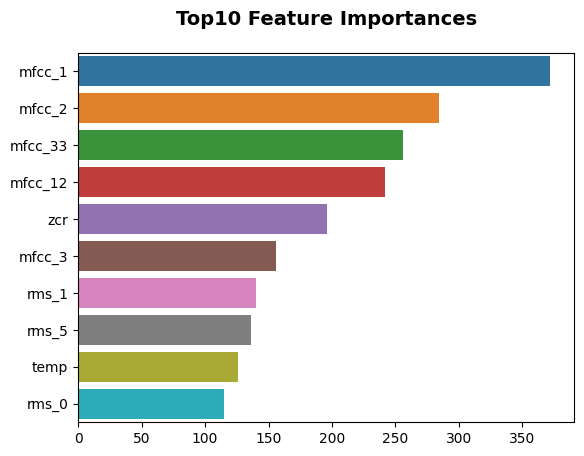

In [86]:
# feature importances
feature_imp = np.stack([i.feature_importances_ for i in model_list], axis=0).mean(axis=0)
top_n = 10
sns.barplot(x=feature_imp[np.argsort(feature_imp)[::-1][:top_n]], y=df_train_x.columns[np.argsort(feature_imp)[::-1][:top_n]])
plt.title(f"Top{top_n} Feature Importances", fontweight="bold", fontsize=14, pad=20)

In [87]:
# threshold optimization
def threshold_optimization(y_pred_prob, y_true):
    search_space = np.arange(5e-2, 0.95 + 1e+3, 5e-2)
    best_score = -np.inf
    best_threshold = 0.5
    for threshold in tqdm(search_space):
        y_pred = (y_pred_prob[:, 1] > threshold).astype("int32")
        score = metrics.f1_score(y_true, y_pred, average="macro")
        if best_score < score:
            best_score = score
            best_threshold = threshold
    return best_score, best_threshold

result = threshold_optimization(
    np.concatenate([np.stack([model.predict_proba(df_train_x.values) for model in model_list]).mean(axis=0), np.stack([model.predict_proba(df_valid_x.values) for model in model_list]).mean(axis=0)], axis=0),
    np.concatenate([df_train_y.values, df_valid_y.values], axis=0),
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20018/20018 [01:07<00:00, 298.64it/s]


In [88]:
print("best threshold :", result[1])
print("best f1 :", result[0])
best_threshold = result[1]

best threshold : 0.55
best f1 : 0.9361570049823347


In [89]:
# evaluation
y_pred_prob = np.stack([model.predict_proba(df_valid_x.values) for model in model_list]).mean(axis=0)
y_pred = (y_pred_prob[:, 1] > best_threshold).astype("int32")

In [90]:
y_pred_prob

array([[0.12322659, 0.87677341],
       [0.12218595, 0.87781405],
       [0.65705988, 0.34294012],
       ...,
       [0.10844113, 0.89155887],
       [0.85104483, 0.14895517],
       [0.78850473, 0.21149527]])

In [91]:
score_dic = {
    "logloss": metrics.log_loss(df_valid_y, y_pred_prob[:, 1]),
    "roc_auc": metrics.roc_auc_score(df_valid_y, y_pred_prob[:, 1]),
    "accuracy": metrics.accuracy_score(df_valid_y, y_pred),
    "f1": metrics.f1_score(df_valid_y, y_pred, average="macro"),
}
print("Valid Score !")
display(score_dic)

Valid Score !


{'logloss': 0.229832756781102,
 'roc_auc': 0.9853136272042108,
 'accuracy': 0.9417658108954289,
 'f1': 0.9346190502393661}

In [92]:
score_dic = pd.Series(score_dic)
score_dic.index.name = "metric"
score_dic.name = "value"
score_dic.to_csv(architecture_path + "./valid_score.csv")

In [93]:
pickleIO(feature_info, architecture_path + "feature_info.pkl", "w")
# pickleIO(feature_scaler, architecture_path + "feature_scaler.pkl", "w")
pickleIO(model_list, architecture_path + "model.pkl", "w")
pickleIO(result, architecture_path + "threshold_opt_resut.pkl", "w")

## Inference

In [94]:
# Save datasets
df_public = pickleIO(None, "./dataset/df_public.pkl", "r")
df_private = pickleIO(None, "./dataset/df_private.pkl", "r")

In [95]:
df_public = df_public.reset_index(drop=True)
df_private = df_private.reset_index(drop=True)

In [96]:
df_public = df_public.drop(["data_path", "timestamp"], axis=1)
df_private = df_private.drop(["data_path", "timestamp"], axis=1)

In [97]:
df_public["type"] = df_public["type"].apply(lambda x: 1 if x == "abdominal" else 0)
df_private["type"] = df_private["type"].apply(lambda x: 1 if x == "abdominal" else 0)

In [98]:
df_public["month"] = df_public["month"] - 1
df_private["month"] = df_private["month"] - 1

In [99]:
# ohe_cols = []
# for i, j in zip(["month", "season"], [list(range(12)), list(range(4))]):
#     ohe_cols.extend([i + "_ohe_" + str(z) for z in j])
# ohe = OneHotEncoder(categories=[list(range(12)), list(range(4))], sparse=False)

df_public[ohe_cols] = ohe.transform(df_public[["month", "season"]])
df_public = df_public.drop(["month", "season"], axis=1)

df_private[ohe_cols] = ohe.transform(df_private[["month", "season"]])
df_private = df_private.drop(["month", "season"], axis=1)

In [100]:
# feature_info = {
#     "target_var": "type",
#     "num_vars": [],
#     "cat_vars": ["month", "season"],
#     "cat_ohe_vars": ohe_cols,
# }
# feature_info["num_vars"] = diff(df_train_x.columns, feature_info["cat_ohe_vars"])
# assert df_train.shape[1] == 1 + len(feature_info["num_vars"]) + len(feature_info["cat_ohe_vars"])

In [101]:
df_public_y = df_public[feature_info["target_var"]]
df_public_x = df_public.drop(feature_info["target_var"], axis=1)

In [102]:
# df_private_y = df_valid[feature_info["target_var"]]
df_private_x = df_private.drop(feature_info["target_var"], axis=1)

In [103]:
# Scaling
# feature_scaler = StandardScaler()
# df_public_x[feature_info["num_vars"]] = feature_scaler.transform(df_public_x[feature_info["num_vars"]])
# df_private_x[feature_info["num_vars"]] = feature_scaler.transform(df_private_x[feature_info["num_vars"]])

In [104]:
df_public_x

,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,month_ohe_6,month_ohe_7,month_ohe_8,month_ohe_9,month_ohe_10,month_ohe_11,season_ohe_0,season_ohe_1,season_ohe_2,season_ohe_3
0,0.110956,-89.557434,125.063660,-46.571136,-3.747338,-37.706070,7.830138,-1.261634,-12.936490,-12.135610,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.087506,-80.624527,156.054886,-35.050068,-13.391775,-25.235804,14.994090,-11.669120,-8.605047,-3.670586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.186968,-50.735058,75.952820,-28.470978,7.182712,-21.798346,13.859969,-3.318800,-6.271745,-14.725714,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.112588,-116.171715,123.856064,-34.556385,9.051366,-20.404308,23.685514,-9.760632,-30.251970,-19.017172,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.100590,-138.776199,151.030258,-56.491470,-9.021966,-18.489534,8.949143,-23.387190,-7.398000,-3.243143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.104608,-150.282227,142.098907,-54.135380,-3.080273,-14.812419,18.932304,-11.928781,-15.391437,-14.131960,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
795,0.094407,-134.003265,119.577377,-22.727446,9.215203,-21.032345,3.065584,-1.430336,-0.362329,-5.982047,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
796,0.094003,-103.170349,120.899429,-18.977919,19.382504,-14.613547,9.250574,-6.324740,-4.161216,-4.539401,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
797,0.198628,-52.819813,65.408615,-37.909309,6.208618,-18.586807,7.424685,-7.032387,-4.572153,-12.765714,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [105]:
df_private_x

,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,month_ohe_6,month_ohe_7,month_ohe_8,month_ohe_9,month_ohe_10,month_ohe_11,season_ohe_0,season_ohe_1,season_ohe_2,season_ohe_3
0,0.085824,-41.678864,149.968658,-48.233906,-1.800263,-18.010992,4.752290,-5.133750,-17.602087,-12.173831,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.084620,-110.671158,131.303391,-25.317749,18.519566,-4.765354,12.664021,-4.798347,-5.396777,-11.744967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.132524,-111.933411,94.765083,-25.611715,30.178749,-3.314769,25.253778,-7.062987,-6.442482,-7.740459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.109668,-194.579407,117.146141,-20.005119,13.343823,-18.698034,13.717471,-8.391618,-2.411869,-7.403742,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.117185,-117.651680,123.144905,-48.442142,13.757357,-35.081715,8.922947,-7.641357,2.589201,-17.886257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,0.099045,-110.524414,127.327431,-56.015804,3.840667,-16.091488,0.567365,-20.529875,-18.644867,-7.152408,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
794,0.157367,-98.115288,88.244949,-26.500019,21.905132,-22.551311,6.663201,-3.335707,-0.123586,-14.705309,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
795,0.115251,-168.447586,129.118118,-60.786858,15.151078,-16.958685,5.779112,-21.899521,-12.638125,-13.240309,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
796,0.112706,-76.409996,124.344589,-50.045509,-2.472262,-16.387707,10.974265,-6.446856,-9.092157,-10.197817,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### public dataset

In [106]:
y_pred_prob = np.stack([model.predict_proba(df_public_x.values) for model in model_list]).mean(axis=0)
y_pred = (y_pred_prob[:, 1] > best_threshold).astype("int32")
pickleIO({"prob": y_pred_prob, "pred": y_pred}, architecture_path + "./lb_submission.pkl", "w")

In [107]:
y_pred_prob

array([[0.12059832, 0.87940168],
       [0.11470943, 0.88529057],
       [0.87705146, 0.12294854],
       ...,
       [0.82052149, 0.17947851],
       [0.87848529, 0.12151471],
       [0.48474935, 0.51525065]])

In [108]:
score_dic = {
    "logloss": metrics.log_loss(df_public_y, y_pred_prob[:, 1]),
    "roc_auc": metrics.roc_auc_score(df_public_y, y_pred_prob[:, 1]),
    "accuracy": metrics.accuracy_score(df_public_y, y_pred),
    "f1": metrics.f1_score(df_public_y, y_pred, average="macro"),
}
print("LB Score !")
display(score_dic)

LB Score !


{'logloss': 0.23623854024944926,
 'roc_auc': 0.9848019297313596,
 'accuracy': 0.9399249061326659,
 'f1': 0.9319845638726519}

In [109]:
score_dic = pd.Series(score_dic)
score_dic.index.name = "metric"
score_dic.name = "value"
score_dic.to_csv(architecture_path + "./lb_score.csv")

### private dataset

In [110]:
y_pred_prob = np.stack([model.predict_proba(df_private_x.values) for model in model_list]).mean(axis=0)
y_pred = [1 if i > result[1] else 0 for i in y_pred_prob[:, 1]]
pickleIO({"prob": y_pred_prob, "pred": y_pred}, architecture_path + "./submission.pkl", "w")

In [111]:
y_pred_prob

array([[0.11986622, 0.88013378],
       [0.14893287, 0.85106713],
       [0.60129087, 0.39870913],
       ...,
       [0.11453911, 0.88546089],
       [0.1230751 , 0.8769249 ],
       [0.59442552, 0.40557448]])